# **Step 1: Data Collection**

In [1]:
import pandas as pd

df= pd.read_csv("taxi_fare.csv") #Loading dataset
print("Preview of dataset:")
print(df.head())
print("\nDataset shape:",df.shape)
print("\nData types:")
print(df.dtypes) #Column names with datatypes

Preview of dataset:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2016-03-01 00:00:00   2016-03-01 00:07:55                1   
1         1  2016-03-01 00:00:00   2016-03-01 00:11:06                1   
2         2  2016-03-01 00:00:00   2016-03-01 00:31:06                2   
3         2  2016-03-01 00:00:00   2016-03-01 00:00:00                3   
4         2  2016-03-01 00:00:00   2016-03-01 00:00:00                5   

   pickup_longitude  pickup_latitude  RatecodeID store_and_fwd_flag  \
0        -73.976746        40.765152           1                  N   
1        -73.983482        40.767925           1                  N   
2        -73.782021        40.644810           1                  N   
3        -73.863419        40.769814           1                  N   
4        -73.971741        40.792183           3                  N   

   dropoff_longitude  dropoff_latitude  payment_type  fare_amount  extra  \
0         -74.004265      

# **Step 2: Data Understanding**
**A] Checking for duplicates, missing values, desciptive statistics and unique values.**

In [2]:
#duplication
duplicates= df.duplicated().sum()
print("Number of duplicate rows:",duplicates)

#missing values
missing=df.isnull().sum()
print("\nMissing values per column:\n",missing)

#Descriptive stats
print("\nDescriptive statistics:\n",df.describe())

#Unique values in categorical cols
print("\nUnique Vendor IDs:", df["VendorID"].unique())
print("Unique Ratecode IDs:", df["RatecodeID"].unique())
print("Unique store_and_fwd_flag:", df["store_and_fwd_flag"].unique())
print("Unique payment types:", df["payment_type"].unique())

Number of duplicate rows: 0

Missing values per column:
 VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

Descriptive statistics:
             VendorID  passenger_count  pickup_longitude  pickup_latitude  \
count  212345.000000    212345.000000     212345.000000    212345.000000   
mean        1.708338         1.766493        -73.112122        40.279405   
std         0.454529         1.469647          7.936633         4.370714   
min         1.000000         0.000000       -121.933327         0.000000   
25%         1.000000         1.000000 

**B] Data Cleaning**

In [3]:
#Drop missing values
df=df.dropna()

#invalid passenger counts(0 or more than 6)
df=df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

#Filter coordinates within NYC boundaries
df=df[(df['pickup_latitude'].between(40, 42)) &
        (df['pickup_longitude'].between(-75, -72)) &
        (df['dropoff_latitude'].between(40, 42)) &
        (df['dropoff_longitude'].between(-75, -72))]

#Remove rows with negative fare, tip, tax, surcharge, or total
df=df[(df['fare_amount']>=0) &
        (df['tip_amount']>=0) &
        (df['mta_tax']>=0) &
        (df['improvement_surcharge']>=0) &
        (df['total_amount']>=0)]

#Remove extreme outliers(cap fares at $250 for reasonable trips)
df=df[df['fare_amount']<= 250]

print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (209535, 18)


In [4]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')

# **Step 3: Feature Engineering**

In [5]:
import numpy as np

#Ensure pickup_datetime is datetime type
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

#Extracting the datetime features
df['year']= df['tpep_pickup_datetime'].dt.year
df['month']= df['tpep_pickup_datetime'].dt.month
df['day']= df['tpep_pickup_datetime'].dt.day
df['day_of_week']= df['tpep_pickup_datetime'].dt.dayofweek
df['hour']= df['tpep_pickup_datetime'].dt.hour

df['trip_duration']=(df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).dt.total_seconds()/60 #Trip dist in mins

#Func to calc haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R= 6371  #Earth's radius in km
    phi1,phi2=np.radians(lat1),np.radians(lat2)
    dphi=np.radians(lat2-lat1)
    dlambda=np.radians(lon2-lon1)

    a=np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arctan2(np.sqrt(a),np.sqrt(1-a))

#Creating the distance feature
df['trip_distance']= haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

#Preview of new features
print(df[['tpep_pickup_datetime','year','month','day','day_of_week','hour','trip_distance','trip_duration']].head())

  tpep_pickup_datetime  year  month  day  day_of_week  hour  trip_distance  \
0           2016-03-01  2016      3    1            1     0       3.138096   
1           2016-03-01  2016      3    1            1     0       4.303331   
2           2016-03-01  2016      3    1            1     0      16.600142   
3           2016-03-01  2016      3    1            1     0       9.046547   
4           2016-03-01  2016      3    1            1     0      20.400022   

   trip_duration  
0       7.916667  
1      11.100000  
2      31.100000  
3       0.000000  
4       0.000000  


In [6]:
#Removing trips with invalid features
df=df[(df['trip_duration']>0) & (df['trip_distance']>0)]
#Removing extreme outlier trips
df=df[(df['trip_duration']<500) & (df['trip_distance']<100)]
df.shape

(208389, 25)

In [7]:
#Weekend flag
df['is_weekend']= df['day_of_week'].apply(lambda x: 1 if x>=5 else 0)
#AM/PM flag
df['am_pm']= df['hour'].apply(lambda x: 'AM' if x<12 else 'PM')
#Night ride's flag(Night=10pm to 5am)
df['is_night']= df['hour'].apply(lambda x: 1 if (x>=22 or x<=5) else 0)

print(df[['hour','day_of_week','is_weekend','am_pm','is_night']])

        hour  day_of_week  is_weekend am_pm  is_night
0          0            1           0    AM         1
1          0            1           0    AM         1
2          0            1           0    AM         1
7          0            1           0    AM         1
8          0            1           0    AM         1
...      ...          ...         ...   ...       ...
212340    12            1           0    PM         0
212341    12            1           0    PM         0
212342    12            1           0    PM         0
212343    12            1           0    PM         0
212344    12            1           0    PM         0

[208389 rows x 5 columns]


# **Step 4: Exploratory Data Analysis**
**A] Univariate Analysis– distributions**

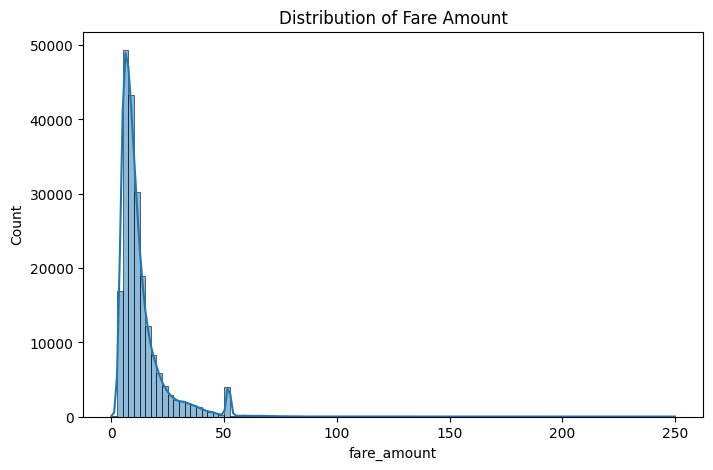

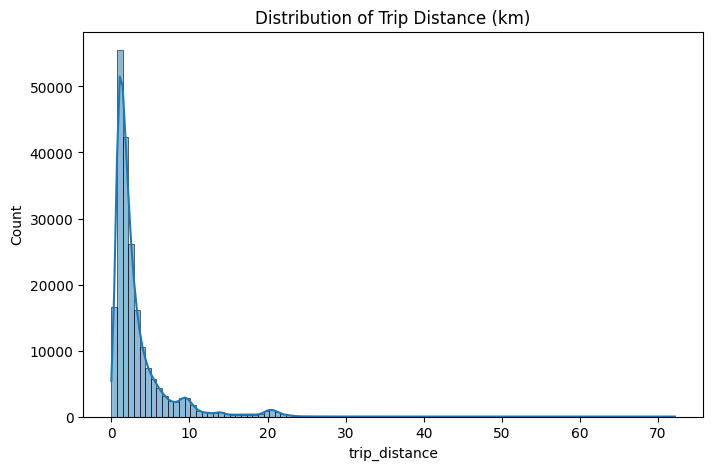

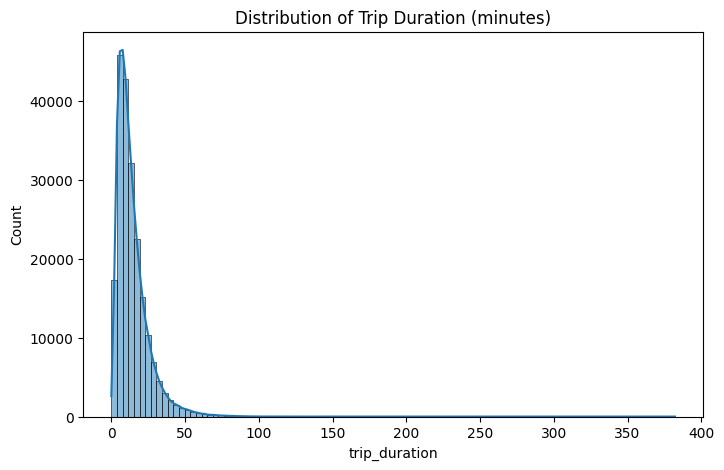

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#Distribution of fare amt.
plt.figure(figsize=(8,5))
sns.histplot(df['fare_amount'], bins=100, kde=True)
plt.title("Distribution of Fare Amount")
plt.show()

#Distribution of trip dist.
plt.figure(figsize=(8,5))
sns.histplot(df['trip_distance'], bins=100, kde=True)
plt.title("Distribution of Trip Distance (km)")
plt.show()

#Distribution of trip duration
plt.figure(figsize=(8,5))
sns.histplot(df['trip_duration'], bins=100, kde=True)
plt.title("Distribution of Trip Duration (minutes)")
plt.show()

**B] Bivariate Analysis– Relationships**

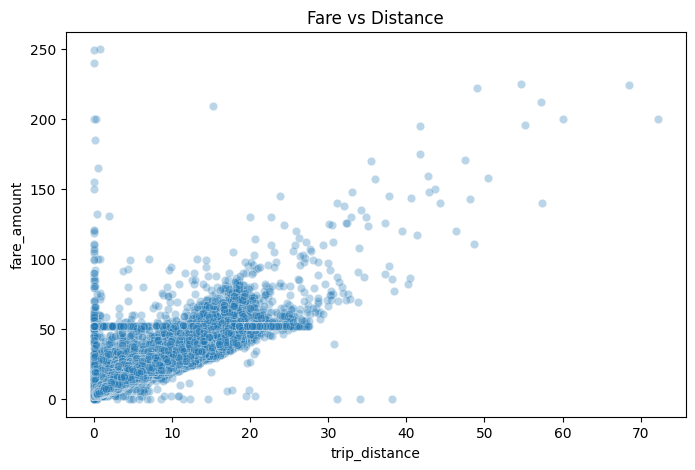

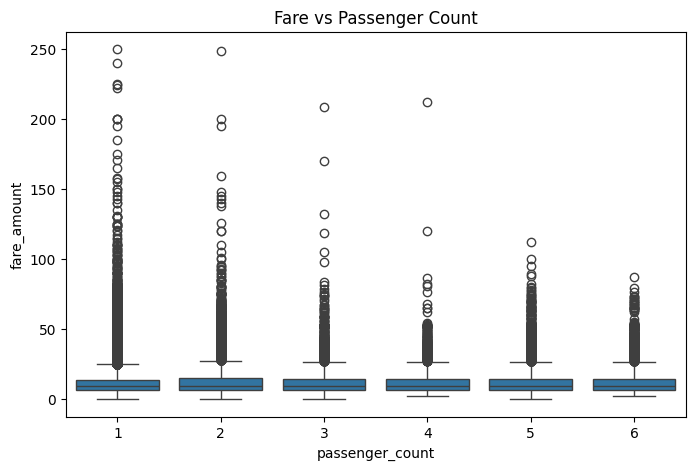

In [9]:
#Fare vs Distance
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df, alpha=0.3)
plt.title("Fare vs Distance")
plt.show()

#Fare vs Passenger Count
plt.figure(figsize=(8,5))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title("Fare vs Passenger Count")
plt.show()

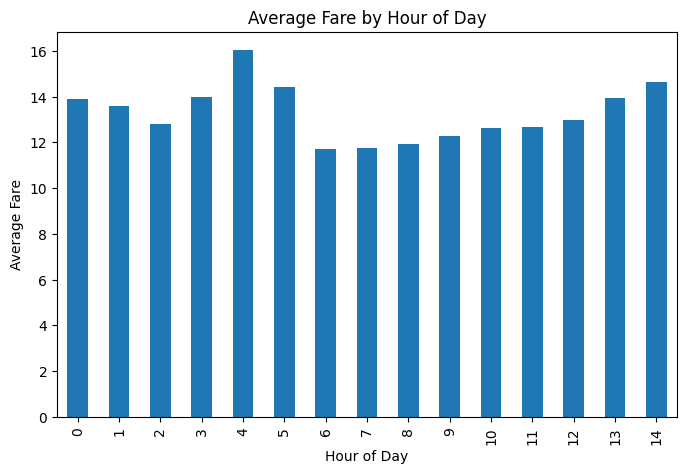

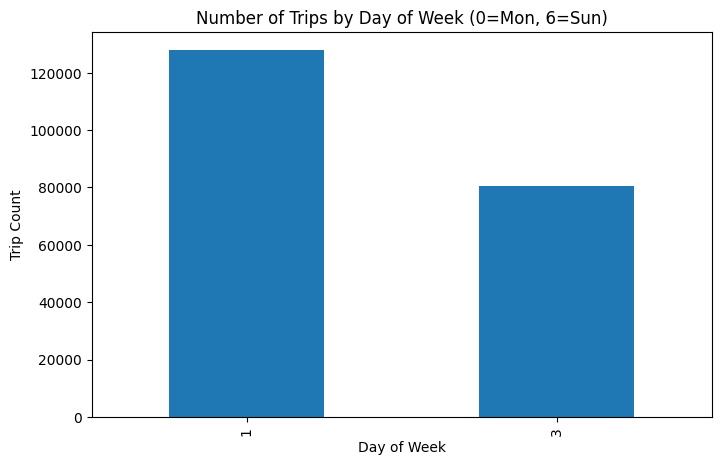

In [10]:
#Avg. fare by hour
hourly_fare=df.groupby('hour')['fare_amount'].mean()
plt.figure(figsize=(8,5))
hourly_fare.plot(kind='bar')
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare")
plt.show()

#Trip counts by day of week
dow_counts=df['day_of_week'].value_counts().sort_index()
plt.figure(figsize=(8,5))
dow_counts.plot(kind='bar')
plt.title("Number of Trips by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Trip Count")
plt.show()

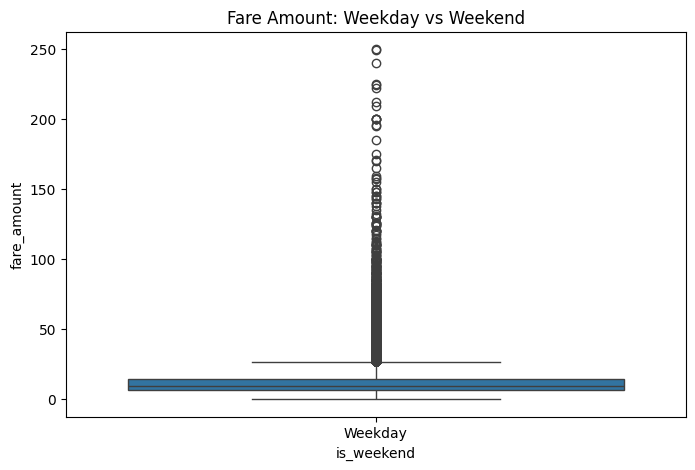

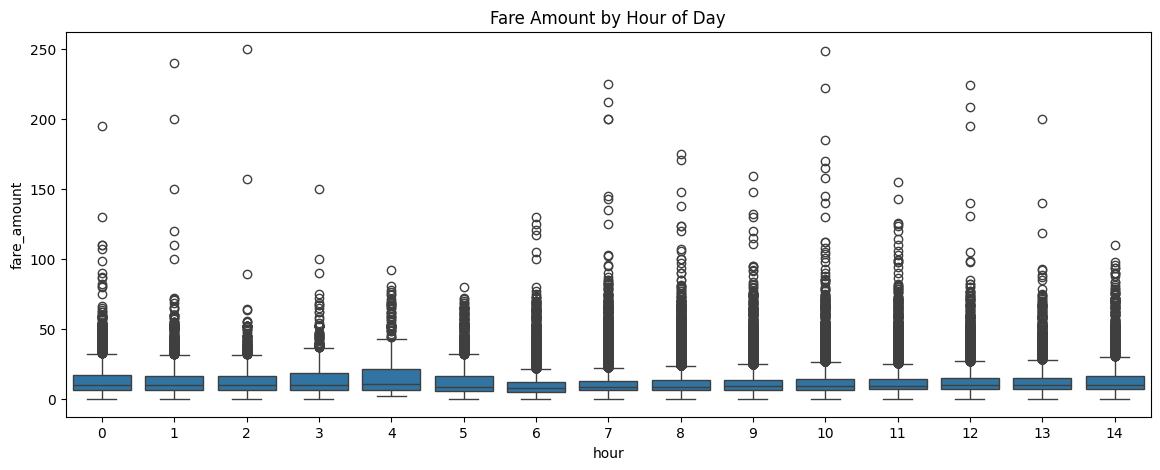

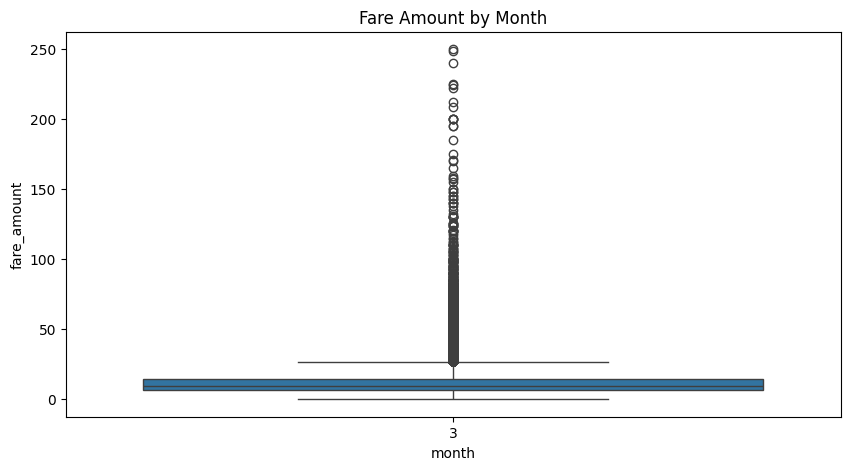

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#Weekday vs Weekend
df['is_weekend']= df['day_of_week'].isin([5,6])  #Sat=5,Sun=6

plt.figure(figsize=(8,5))
sns.boxplot(x='is_weekend', y='fare_amount', data=df)
plt.xticks([0], ['Weekday'])
plt.title("Fare Amount: Weekday vs Weekend")
plt.show()

#Hourly variation
plt.figure(figsize=(14,5))
sns.boxplot(x='hour', y='fare_amount', data=df)
plt.title("Fare Amount by Hour of Day")
plt.show()

#Monthly variation
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='fare_amount', data=df)
plt.title("Fare Amount by Month")
plt.show()

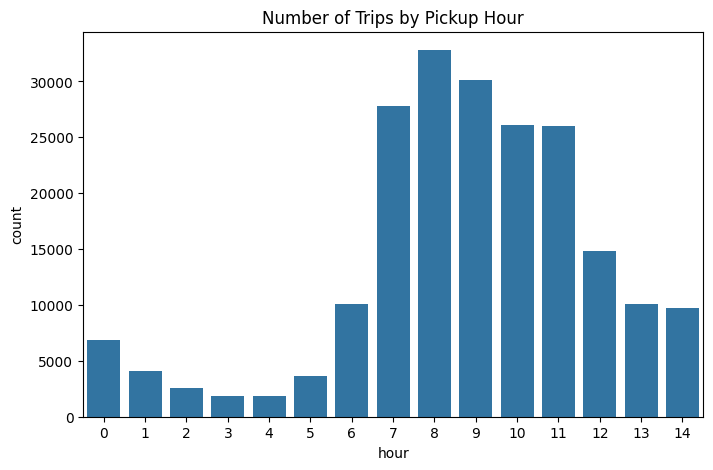

In [12]:
#Pickup hours
plt.figure(figsize=(8,5))
sns.countplot(x='hour', data=df)
plt.title("Number of Trips by Pickup Hour")
plt.show()

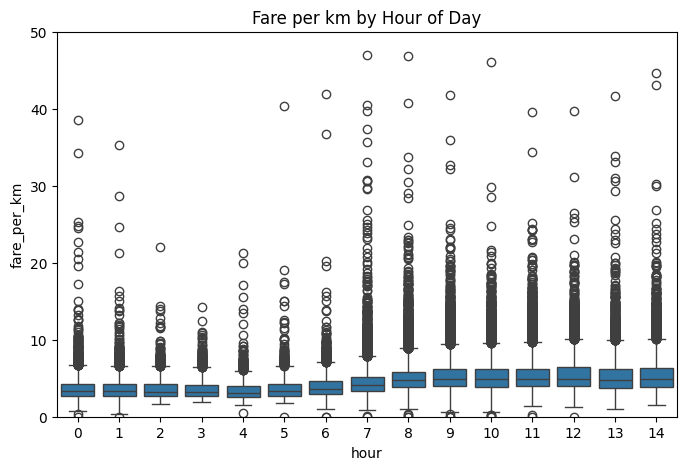

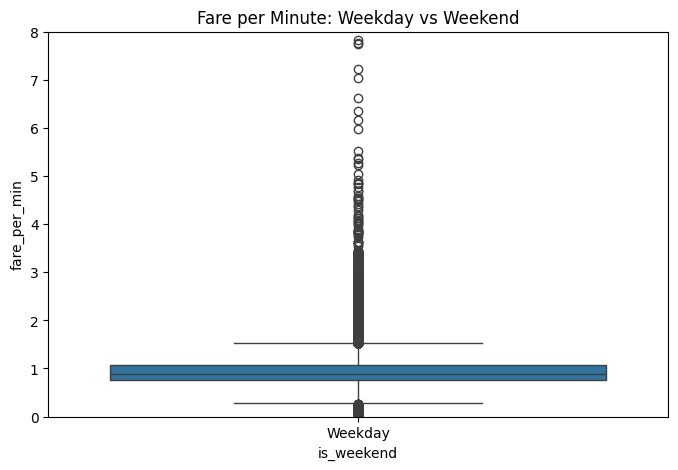

In [13]:
#Filter out unrealistic trips
df=df[(df['trip_distance'] > 0.5) & (df['trip_duration'] > 1)] #at least 0.5 km and 1 min
df['fare_per_km'] = df['fare_amount'] / df['trip_distance']
df['fare_per_min'] = df['fare_amount'] / df['trip_duration']
#Drop infinite/nan
df=df.replace([np.inf, -np.inf], np.nan).dropna(subset=['fare_per_km','fare_per_min'])

plt.figure(figsize=(8,5))
sns.boxplot(x='hour', y='fare_per_km', data=df)
plt.title("Fare per km by Hour of Day")
plt.ylim(0,50)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='is_weekend', y='fare_per_min', data=df)
plt.xticks([0], ['Weekday'])
plt.title("Fare per Minute: Weekday vs Weekend")
plt.ylim(0,8)
plt.show()

# **Step 5: Data Transformation**


**A) Handling Outliers using IQR Method**

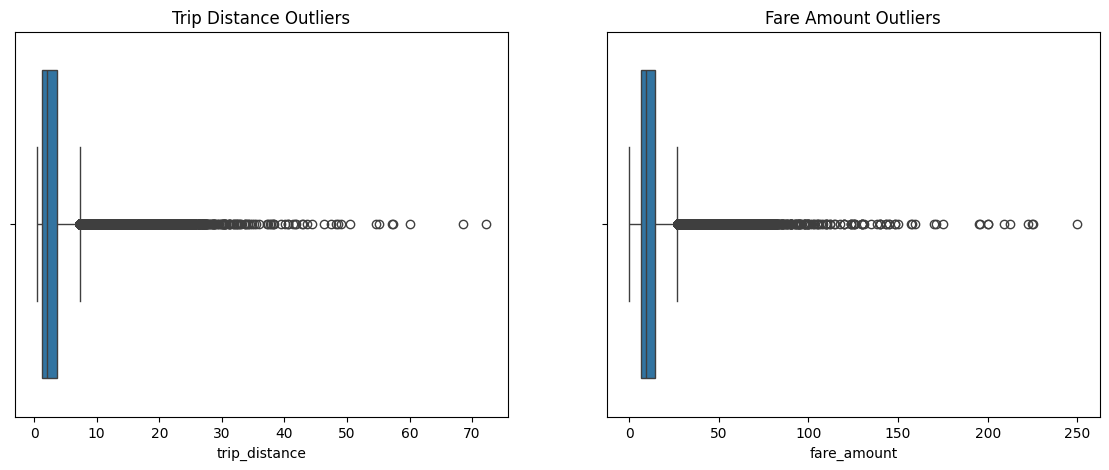

Trip Distance Stats:
count    202176.000000
mean          3.320426
std           3.749982
min           0.500014
25%           1.240540
50%           2.020791
75%           3.673043
max          72.164010
Name: trip_distance, dtype: float64

Fare Amount Stats:
count    202176.000000
mean         12.811409
std          10.304827
min           0.000000
25%           6.500000
50%           9.500000
75%          14.500000
max         250.000000
Name: fare_amount, dtype: float64
After outlier removal: (167677, 30)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

#Boxplots for outlier visualization
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(x=df['trip_distance'])
plt.title("Trip Distance Outliers")

plt.subplot(1,2,2)
sns.boxplot(x=df['fare_amount'])
plt.title("Fare Amount Outliers")
plt.show()

#Check outlier statistics
print("Trip Distance Stats:")
print(df['trip_distance'].describe())

print("\nFare Amount Stats:")
print(df['fare_amount'].describe())

#Remove outliers using IQR method for selected columns only
def remove_outliers_iqr(df, column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR= Q3-Q1
    lower= Q1-1.5*IQR
    upper= Q3+1.5*IQR
    return df[(df[column]>=lower) & (df[column]<=upper)]

#Apply to selected columns
for col in ['fare_amount', 'trip_distance', 'trip_duration', 'total_amount']:
    df=remove_outliers_iqr(df, col)

print("After outlier removal:", df.shape)

**B) Fix skewness in continuous variables**

**C) Encode categorical variables**




In [15]:
import numpy as np
import pandas as pd

#Fix Skewness using cont. numeric features(no IDs or categorical cols.)
skewed_features=[
    'trip_distance', 'fare_amount', 'extra', 'mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'fare_per_min', 'fare_per_km']

for col in skewed_features:
    if col in df.columns:  #only apply if column exists
        df[col]=df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)

print("Skewness fixed for continuous variables.")

#encode the categorical cols.
categorical_cols=['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']
df=pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Categorical variables encoded.")
print(f"Final dataset shape after Step 5: {df.shape}")
print("Sample columns:", df.columns.tolist()[:20])

Skewness fixed for continuous variables.
Categorical variables encoded.
Final dataset shape after Step 5: (167677, 36)
Sample columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'year', 'month', 'day', 'day_of_week', 'hour', 'trip_duration']


In [16]:
print(df.columns.tolist())

['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'year', 'month', 'day', 'day_of_week', 'hour', 'trip_duration', 'trip_distance', 'is_weekend', 'am_pm', 'is_night', 'fare_per_km', 'fare_per_min', 'VendorID_2', 'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5', 'RatecodeID_99', 'store_and_fwd_flag_Y', 'payment_type_2', 'payment_type_3', 'payment_type_4']


# **Step 6: Feature Selection**

Initial dataset shape: (167677, 36)


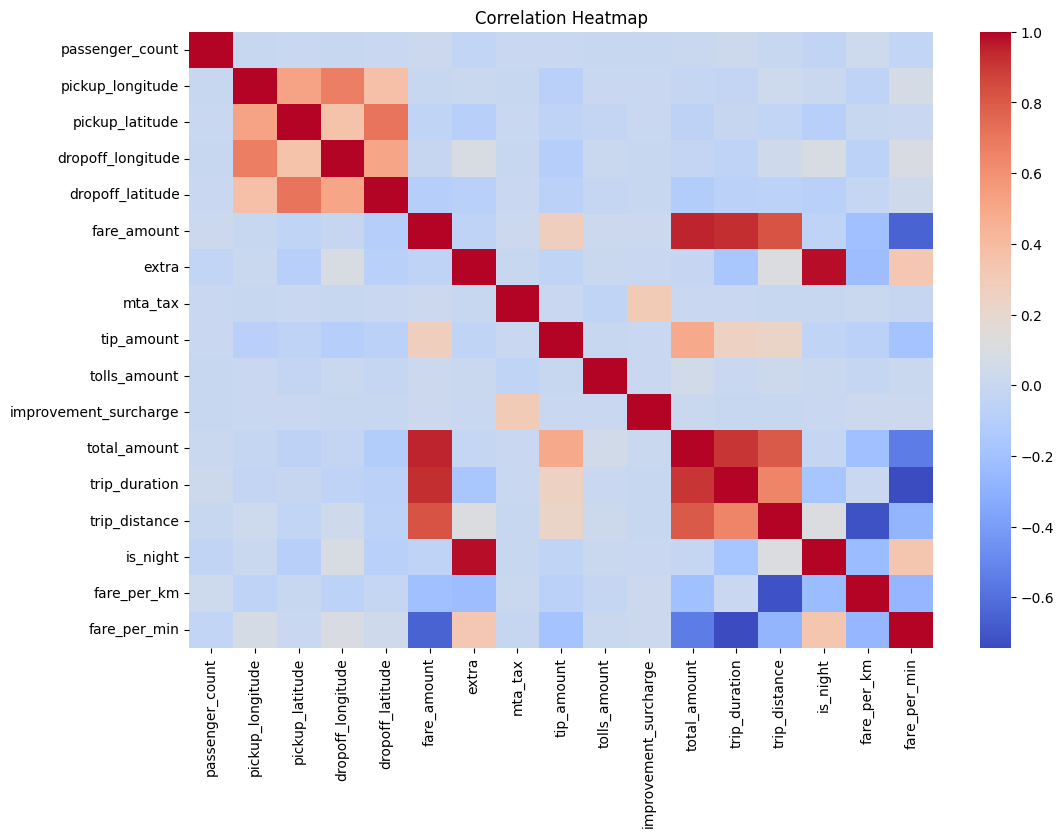

Highly correlated pairs (corr > 0.85): ['fare_amount', 'extra', 'trip_duration', 'is_night']
After correlation filtering, dataset shape: (167677, 32)
Categorical columns considered for Chi-Square: ['passenger_count', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'day_of_week', 'is_weekend', 'am_pm', 'VendorID_2', 'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5', 'RatecodeID_99', 'store_and_fwd_flag_Y', 'payment_type_2', 'payment_type_3', 'payment_type_4']

Chi-Square Scores (higher=more important):
payment_type_2           7709.804489
day_of_week               216.171871
tolls_amount              176.500722
am_pm                     142.521234
VendorID_2                 53.205597
payment_type_3             17.590071
payment_type_4             14.299972
passenger_count            12.079101
RatecodeID_4                6.005395
RatecodeID_3                6.005395
RatecodeID_5                3.765497
RatecodeID_2                2.998593
RatecodeID_99               2.99

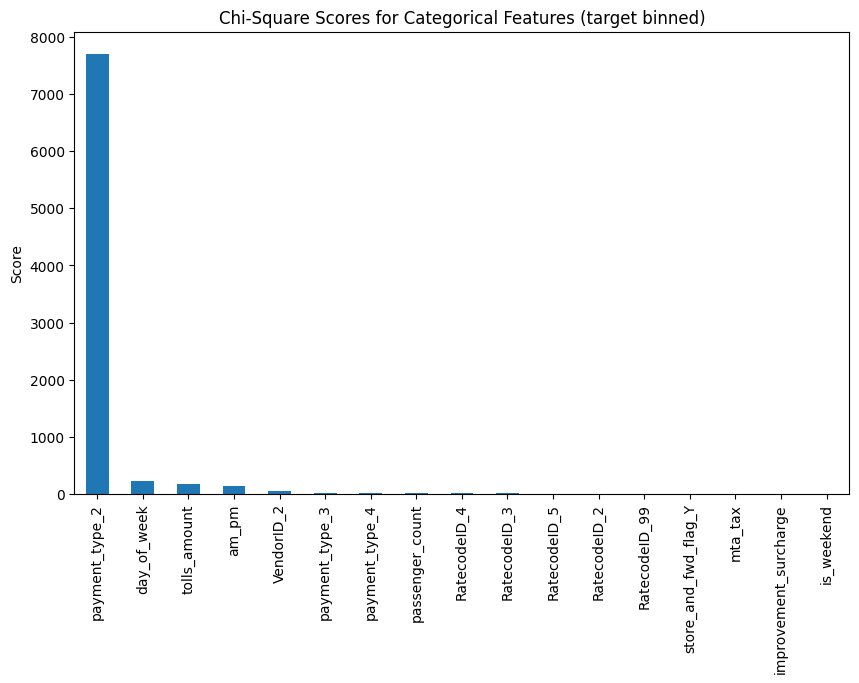

y shape: (167677,)
X shape (numeric features only): (167677, 18)
Sample X columns: ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'year', 'month', 'day', 'day_of_week', 'hour', 'trip_distance', 'am_pm', 'fare_per_km', 'fare_per_min']


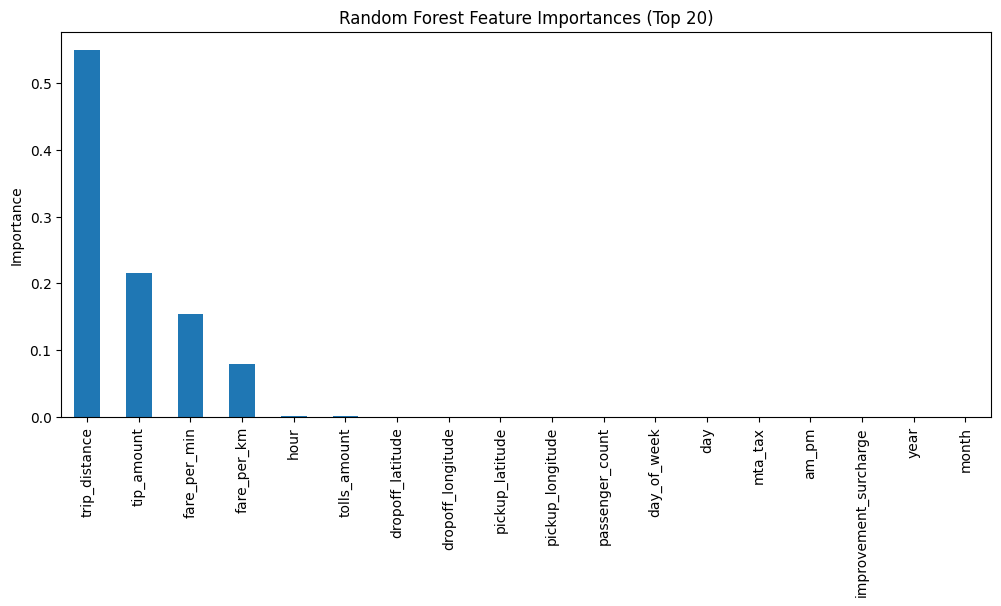


Top features by RandomForest:
trip_distance            0.549281
tip_amount               0.216082
fare_per_min             0.153473
fare_per_km              0.078672
hour                     0.000718
tolls_amount             0.000646
dropoff_latitude         0.000253
dropoff_longitude        0.000249
pickup_latitude          0.000240
pickup_longitude         0.000216
passenger_count          0.000059
day_of_week              0.000039
day                      0.000032
mta_tax                  0.000023
am_pm                    0.000014
improvement_surcharge    0.000003
year                     0.000000
month                    0.000000
dtype: float64


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

print("Initial dataset shape:", df.shape)
#1.Correlation analysis
numeric_df=df.select_dtypes(include=["int64", "float64"])
corr_matrix=numeric_df.corr()

#plotting corr. heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

#Drop highly correlated features (keep target 'total_amount')
threshold=0.85
to_drop=set()
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and abs(corr_matrix.loc[i,j]) > threshold:
            if j != "total_amount":   #not to drop the target
                to_drop.add(j)

print("Highly correlated pairs (corr > 0.85):", list(to_drop))
df=df.drop(columns=list(to_drop), errors="ignore")
print("After correlation filtering, dataset shape:", df.shape)

#2.Chi-Square Test
#Select categorical features (dummy vars + engineered categoricals)
categorical_cols=[col for col in df.columns if ("_" in col and df[col].nunique() <= 10)]
for col in ["is_weekend", "am_pm", "day_of_week"]:
    if col in df.columns and col not in categorical_cols:
        categorical_cols.append(col)

print("Categorical columns considered for Chi-Square:", categorical_cols)

#Encode string-based categoricals if any (safety)
for col in categorical_cols:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

#Discretize target
y_binned=pd.qcut(df["total_amount"], q=4, labels=False)

if categorical_cols:
    X_cat = MinMaxScaler().fit_transform(df[categorical_cols])

    chi2_selector = SelectKBest(score_func=chi2, k="all")
    chi2_selector.fit(X_cat, y_binned)

    chi2_scores = pd.Series(chi2_selector.scores_, index=categorical_cols).sort_values(ascending=False)
    print("\nChi-Square Scores (higher=more important):")
    print(chi2_scores)

    plt.figure(figsize=(10,6))
    chi2_scores.plot(kind="bar")
    plt.title("Chi-Square Scores for Categorical Features (target binned)")
    plt.ylabel("Score")
    plt.show()

#3.RandomForest
from sklearn.ensemble import RandomForestRegressor
#target is cont.
y=df["total_amount"].astype(float)
print("y shape:", y.shape)

#Build X: drop target and any raw datetime columns (we keep engineered time features like hour/is_night)
drop_cols=["total_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime"]
drop_cols=[c for c in drop_cols if c in df.columns]

X=df.drop(columns=drop_cols, errors=True)

#Keep only numeric columns for the model (this removes datetime/object automatically)
X=X.select_dtypes(include=[np.number]).copy()

#Replace inf/-inf and fill NaNs (simple strategy — later you can impute more carefully)
X=X.replace([np.inf, -np.inf], np.nan).fillna(0)
print("X shape (numeric features only):", X.shape)
print("Sample X columns:", X.columns.tolist()[:20])

#Fit RandomForest
rf=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

importances=pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

#Plot top 20 importances
plt.figure(figsize=(12,5))
importances.head(20).plot(kind="bar")
plt.title("Random Forest Feature Importances (Top 20)")
plt.ylabel("Importance")
plt.show()

print("\nTop features by RandomForest:")
print(importances.head(20))

# **Step 7: Model Building**

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

#1.Drop datetime columns (not usable directly in ML models)
X=df.drop(columns=['total_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'])
y=df['total_amount']

#2.Train-test split
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42
)

#3.Define models
models={
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results={}

#4.training & evaluating models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    r2=r2_score(y_test, y_pred)
    mse=mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    mae=mean_absolute_error(y_test, y_pred)

    results[name]={
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

#5.result table
results_df=pd.DataFrame(results).T
print("Model Performance Comparison:")
display(results_df.sort_values(by="R2", ascending=False))

Model Performance Comparison:


,R2,MSE,RMSE,MAE
Random Forest,0.996925,0.052477,0.229078,0.070538
Gradient Boosting,0.974364,0.437505,0.661442,0.467195
Ridge Regression,0.970207,0.508458,0.713062,0.503479
Linear Regression,0.970187,0.508793,0.713298,0.503524
Lasso Regression,0.970071,0.510770,0.714682,0.505403


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error

#Sample the training set (e.g., 30k rows for tuning)
X_sample = X_train.sample(n=30000, random_state=42)
y_sample = y_train.loc[X_sample.index]

#Random Forest Tuning
rf_param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(3, 12),
    'min_samples_split': randint(2, 8),
    'min_samples_leaf': randint(1, 4)
}

rf_random = RandomizedSearchCV(
    estimator=models['Random Forest'],
    param_distributions=rf_param_dist,
    n_iter=10,               #keep small for speed
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1                 #prevent OSError
)

rf_random.fit(X_sample, y_sample)
print("Best Random Forest Params:", rf_random.best_params_)
best_rf = rf_random.best_estimator_

#Gradient Boosting Tuning
gb_param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.05, 0.2),
    'max_depth': randint(3, 8)
}

gb_random = RandomizedSearchCV(
    estimator=models['Gradient Boosting'],
    param_distributions=gb_param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1                 #prevent OSError
)

gb_random.fit(X_sample, y_sample)
print("Best Gradient Boosting Params:", gb_random.best_params_)
best_gb = gb_random.best_estimator_

#Evaluate tuned models on full test set
tuned_models={
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting (Tuned)': best_gb
}

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)  #use scaled test if you used scaling in training
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  #fix
    print(f"\n{name}:")
    print(f" R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=4, n_estimators=121; total time=  20.4s
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=4, n_estimators=121; total time=  20.1s
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=4, n_estimators=121; total time=  20.6s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=132; total time=  17.3s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=132; total time=  17.5s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=132; total time=  18.1s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=137; total time=  22.2s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=137; total time=  24.2s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=137; total time=  23.3s
[CV] END max_depth=7, min_samples_leaf=

In [24]:
# Step 7.2: Final Retraining with Best Parameters

# Refit best models on the full training data
final_rf = best_rf
final_rf.fit(X_train, y_train)

final_gb = best_gb
final_gb.fit(X_train, y_train)

# Evaluate on test data again
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

for name, model in [("Random Forest", final_rf), ("Gradient Boosting", final_gb)]:
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{name} (Final Retrained):")
    print(f" R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Random Forest (Final Retrained):
 R²: 0.9915, MAE: 0.2138, RMSE: 0.3800

Gradient Boosting (Final Retrained):
 R²: 0.9976, MAE: 0.1316, RMSE: 0.2030


In [25]:
#Step 8:Finalize Best Model and Save
import pickle

#Choose the best model (Gradient Boosting)
best_model = final_gb

#Save the model to pickle file
with open("best_taxi_fare_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved as best_taxi_fare_model.pkl")

Best model saved as best_taxi_fare_model.pkl
